In [1]:

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline



In [2]:
df_flights = pd.read_csv('../FlightData/flights_SFO_UA.csv')
df_planes = pd.read_csv('../PlaneData/MainlineFleet.csv')
df_holiday = pd.read_csv('../HolidayData/holidays_2023_2024.csv')
df_future_flights = pd.read_csv('../FutureData/future_flights_data.csv')
df_weather = pd.read_csv('../WeatherData/hourly_dataframe_past (1).csv')
df_future_weather = pd.read_csv('../WeatherData/hourly_dataframe_forecast (1).csv')


In [3]:
df_planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834 entries, 0 to 1833
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PLANE_MODEL  1819 non-null   object
 1   TAIL_NUM     1584 non-null   object
dtypes: object(2)
memory usage: 28.8+ KB


In [4]:
df_express_fleet = pd.read_csv('../PlaneData/ExpressFleet.csv')
df_mainline_fleet = pd.read_csv('../PlaneData/MainlineFleet.csv')

df_planes = pd.concat([df_express_fleet, df_mainline_fleet], ignore_index=True)

df_flights_plane = df_flights.merge(df_planes[['PLANE_MODEL', 'TAIL_NUM']], how='left', left_on='TAIL_NUM', right_on='TAIL_NUM')

missing_plane_model = df_flights_plane[df_flights_plane['PLANE_MODEL'].isna()]['TAIL_NUM'].unique()
print("Unique TAIL_NUM without a PLANE_MODEL:", missing_plane_model, "count:", len(missing_plane_model))


Unique TAIL_NUM without a PLANE_MODEL: ['N13110' 'N13138' 'N14102' 'N14242' 'N17133' 'N17229' 'N18119' 'N18220'
 'N215UA' 'N222UA' 'N228UA' 'N2331U' 'N2645U' 'N27205' 'N27421' 'N2747U'
 'N29124' 'N29129' 'N34137' 'N37413' 'N37419' 'N37466' 'N37504' 'N38454'
 'N38458' 'N38473' 'N39418' 'N41135' 'N417UA' 'N429UA' 'N437UA' 'N438UA'
 'N445UA' 'N457UA' 'N467UA' 'N468UA' 'N469UA' 'N472UA' 'N476UA' 'N477UA'
 'N48127' 'N487UA' 'N491UA' 'N57111' 'N68807' 'N69819' 'N75426' 'N76503'
 'N76504' 'N76529' 'N76532' 'N77542' 'N779UA' 'N78506' 'N785UA' 'N87512'
 'N14107' 'N14115' 'N14214' 'N14235' 'N19136' 'N19141' 'N21108' 'N2138U'
 'N2142U' 'N220UA' 'N26232' 'N33203' 'N37277' 'N37422' 'N37434' 'N37506'
 'N37510' 'N37513' 'N423UA' 'N441UA' 'N462UA' 'N475UA' 'N496UA' 'N53441'
 'N69806' 'N69816' 'N69818' 'N73259' 'N76514' 'N77430' 'N77535' 'N776UA'
 'N781UA' 'N787UA' 'N793UA' 'N12125' 'N14106' 'N2135U' 'N214UA' 'N27477'
 'N36469' 'N37263' 'N39415' 'N39423' 'N41140' 'N471UA' 'N489UA' 'N76505'
 'N76516' 'N

In [5]:
df_flights_plane['PLANE_MODEL'].unique()

array([nan, '38M', '39M', '787-8', '787-9', '739ER', '753', '763ER',
       '772ER', '319', '752', '77W', '787-10', '764ER', '738'],
      dtype=object)

In [6]:
for origin, dest in df_flights_plane[['ORIGIN_CITY_NAME', 'DEST_CITY_NAME']].drop_duplicates().values:
    mask = (df_flights_plane['ORIGIN_CITY_NAME'] == origin) & (df_flights_plane['DEST_CITY_NAME'] == dest)
    
    plane_model = df_flights_plane.loc[mask, 'PLANE_MODEL'].dropna().unique()
    
    if len(plane_model) > 0:
        df_flights_plane.loc[mask & df_flights_plane['PLANE_MODEL'].isna(), 'PLANE_MODEL'] = plane_model[0]


In [7]:
unique_tail_nums = df_flights_plane['TAIL_NUM'].nunique()
unique_tail_nums_no_model = df_flights_plane[df_flights_plane['PLANE_MODEL'].isna()]['TAIL_NUM'].nunique()
percentage_unique_no_model = (unique_tail_nums_no_model / unique_tail_nums) * 100

total_rows = len(df_flights_plane)
rows_no_model = df_flights_plane['PLANE_MODEL'].isna().sum()
percentage_rows_no_model = (rows_no_model / total_rows) * 100

print(f"Percentage of unique TAIL_NUM that have no model: {percentage_unique_no_model:.2f}%")
print(f"Percentage of all rows that have no model: {percentage_rows_no_model:.2f}%")


Percentage of unique TAIL_NUM that have no model: 0.11%
Percentage of all rows that have no model: 0.00%


In [8]:
df_flights_plane

,ORIGIN_CITY_NAME,ORIGIN_AIRPORT_ID,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,TAIL_NUM,FL_DATE,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEST_CITY_NAME,DEST_AIRPORT_ID,AIR_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,PLANE_MODEL
0,"San Francisco, CA",14771,UA,1665,N13110,2024-02-01,2024,2,1,4,"Boston, MA",10721,329.0,23:44:00,19.0,1.0,752
1,"San Francisco, CA",14771,UA,716,N13110,2024-02-01,2024,2,1,4,"Boston, MA",10721,314.0,08:17:00,-8.0,0.0,752
2,"San Francisco, CA",14771,UA,1999,N13138,2024-02-01,2024,2,1,4,"Denver, CO",11292,122.0,11:42:00,36.0,1.0,38M
3,"San Francisco, CA",14771,UA,2374,N14102,2024-02-01,2024,2,1,4,"Boston, MA",10721,314.0,13:30:00,15.0,1.0,752
4,"San Francisco, CA",14771,UA,1041,N14242,2024-02-01,2024,2,1,4,"San Diego, CA",14679,66.0,08:27:00,-8.0,0.0,39M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50235,"San Francisco, CA",14771,UA,246,N850UA,2023-10-31,2023,10,31,2,"Albuquerque, NM",10140,115.0,11:04:00,-6.0,0.0,319
50236,"San Francisco, CA",14771,UA,1581,N872UA,2023-10-31,2023,10,31,2,"Boise, ID",10713,70.0,08:34:00,-11.0,0.0,319
50237,"San Francisco, CA",14771,UA,1640,N881UA,2023-10-31,2023,10,31,2,"Dallas/Fort Worth, TX",11298,184.0,10:58:00,-8.0,0.0,319
50238,"San Francisco, CA",14771,UA,1107,N884UA,2023-10-31,2023,10,31,2,"Austin, TX",10423,185.0,08:37:00,-3.0,0.0,319


In [9]:
df_flights_plane = df_flights_plane.dropna(subset=['PLANE_MODEL'])

In [10]:
flights_plane_csv_path = '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/flights_plane.csv'
df_flights_plane.to_csv(flights_plane_csv_path, index=False)
print(f"Combined CSV file saved as '{flights_plane_csv_path}'")


Combined CSV file saved as '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/flights_plane.csv'


In [11]:
df_flights_plane.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50239 entries, 0 to 50239
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ORIGIN_CITY_NAME   50239 non-null  object 
 1   ORIGIN_AIRPORT_ID  50239 non-null  int64  
 2   OP_UNIQUE_CARRIER  50239 non-null  object 
 3   OP_CARRIER_FL_NUM  50239 non-null  int64  
 4   TAIL_NUM           50239 non-null  object 
 5   FL_DATE            50239 non-null  object 
 6   YEAR               50239 non-null  int64  
 7   MONTH              50239 non-null  int64  
 8   DAY_OF_MONTH       50239 non-null  int64  
 9   DAY_OF_WEEK        50239 non-null  int64  
 10  DEST_CITY_NAME     50239 non-null  object 
 11  DEST_AIRPORT_ID    50239 non-null  int64  
 12  AIR_TIME           50239 non-null  float64
 13  DEP_TIME           50239 non-null  object 
 14  DEP_DELAY          50239 non-null  float64
 15  DEP_DEL15          50239 non-null  float64
 16  PLANE_MODEL        50239 no

In [12]:
df_flights_plane.head()

,ORIGIN_CITY_NAME,ORIGIN_AIRPORT_ID,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,TAIL_NUM,FL_DATE,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEST_CITY_NAME,DEST_AIRPORT_ID,AIR_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,PLANE_MODEL
0,"San Francisco, CA",14771,UA,1665,N13110,2024-02-01,2024,2,1,4,"Boston, MA",10721,329.0,23:44:00,19.0,1.0,752
1,"San Francisco, CA",14771,UA,716,N13110,2024-02-01,2024,2,1,4,"Boston, MA",10721,314.0,08:17:00,-8.0,0.0,752
2,"San Francisco, CA",14771,UA,1999,N13138,2024-02-01,2024,2,1,4,"Denver, CO",11292,122.0,11:42:00,36.0,1.0,38M
3,"San Francisco, CA",14771,UA,2374,N14102,2024-02-01,2024,2,1,4,"Boston, MA",10721,314.0,13:30:00,15.0,1.0,752
4,"San Francisco, CA",14771,UA,1041,N14242,2024-02-01,2024,2,1,4,"San Diego, CA",14679,66.0,08:27:00,-8.0,0.0,39M


In [13]:
df_future_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   clean_date         203 non-null    object
 1   carrier            203 non-null    object
 2   flightnumber       203 non-null    int64 
 3   airport_name       203 non-null    object
 4   airport_city_name  203 non-null    object
 5   airport_IATA       203 non-null    object
 6   aircraft_name      203 non-null    object
 7   aircraft_IATA      203 non-null    object
 8   departure_time     203 non-null    object
 9   arrival_time       203 non-null    object
 10  elapsed_time       203 non-null    int64 
 11  codeshare_info     186 non-null    object
dtypes: int64(2), object(10)
memory usage: 19.2+ KB


In [14]:
df_future_flights.head()

,clean_date,carrier,flightnumber,airport_name,airport_city_name,airport_IATA,aircraft_name,aircraft_IATA,departure_time,arrival_time,elapsed_time,codeshare_info
0,2024-05-31,UA,512,George Bush Intcntl Houston,Houston,IAH,Boeing 737MAX 9 Passenger,7M9,00:30,06:26:00,236,NZ 9190 /VA 8082
1,2024-05-31,UA,189,Ninoy Aquino International,Manila,MNL,Boeing 777-300ER,77W,00:45,05:55:00,850,NaN
2,2024-05-31,UA,1139,Chicago Ohare International,Chicago,ORD,Boeing 737-900 Passenger,739,01:10,07:30:00,260,AC 3088 /NZ 9308
3,2024-05-31,UA,274,George Bush Intcntl Houston,Houston,IAH,Boeing 737MAX 9 Passenger,7M9,05:00,11:03:00,243,NZ 9198 /VA 8084
4,2024-05-31,UA,1003,Denver International,Denver,DEN,Boeing 757-300 Passenger,753,05:00,08:37:00,157,AC 4046 /NZ 9057 /VA 8335


In [15]:
df_flights_plane['DEST_CITY_NAME'] = df_flights_plane['DEST_CITY_NAME'].str.replace(r',.*', '', regex=True)
df_flights_plane['ORIGIN_CITY_NAME'] = df_flights_plane['ORIGIN_CITY_NAME'].str.replace(r',.*', '', regex=True)

/var/folders/hx/g2lg_kq17xgb1zndw9jlbyn80000gn/T/ipykernel_46091/506844661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights_plane['DEST_CITY_NAME'] = df_flights_plane['DEST_CITY_NAME'].str.replace(r',.*', '', regex=True)
/var/folders/hx/g2lg_kq17xgb1zndw9jlbyn80000gn/T/ipykernel_46091/506844661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights_plane['ORIGIN_CITY_NAME'] = df_flights_plane['ORIGIN_CITY_NAME'].str.replace(r',.*', '', regex=True)


In [16]:

df_future_flights = df_future_flights.drop(columns=[
    'flightnumber', 
    'airport_name', 
    'airport_IATA', 
    'aircraft_name', 
    'arrival_time', 
    'codeshare_info',
    'carrier'
])

df_future_flights = df_future_flights.rename(columns={
    'clean_date': 'FL_DATE',
    'airport_city_name': 'DEST_CITY_NAME',
    'aircraft_IATA': 'PLANE_MODEL',
    'departure_time': 'DEP_TIME',
    'elapsed_time': 'AIR_TIME'
})


In [17]:
columns_to_drop = [
    'ORIGIN_AIRPORT_ID', 
    'OP_UNIQUE_CARRIER', 
    'OP_CARRIER_FL_NUM', 
    'TAIL_NUM', 
    'YEAR', 
    'MONTH', 
    'DAY_OF_MONTH', 
    'DEST_AIRPORT_ID', 
    'DEP_DELAY',
    'ORIGIN_CITY_NAME'
]

df_flights_plane = df_flights_plane.drop(columns=columns_to_drop)

In [18]:
df_future_flights['FL_DATE'] = pd.to_datetime(df_future_flights['FL_DATE'])
df_future_flights['DAY_OF_WEEK'] = df_future_flights['FL_DATE'].dt.dayofweek
df_flights_plane['FL_DATE'] = pd.to_datetime(df_flights_plane['FL_DATE'])
df_flights_plane['DAY_OF_WEEK'] = df_flights_plane['FL_DATE'].dt.dayofweek

In [19]:
df_future_flights

,FL_DATE,DEST_CITY_NAME,PLANE_MODEL,DEP_TIME,AIR_TIME,DAY_OF_WEEK
0,2024-05-31,Houston,7M9,00:30,236,4
1,2024-05-31,Manila,77W,00:45,850,4
2,2024-05-31,Chicago,739,01:10,260,4
3,2024-05-31,Houston,7M9,05:00,243,4
4,2024-05-31,Denver,753,05:00,157,4
...,...,...,...,...,...,...
198,2024-05-31,Taipei,777,23:45,800,4
199,2024-05-31,Hong Kong,77W,23:50,850,4
200,2024-05-31,Seoul,777,23:55,745,4
201,2024-05-31,Houston,777,23:59,235,4


In [20]:
columns_order_future = ['FL_DATE', 'DAY_OF_WEEK', 'DEST_CITY_NAME', 'AIR_TIME', 'DEP_TIME', 'PLANE_MODEL']
df_future_flights = df_future_flights[columns_order_future]
columns_order_past = ['FL_DATE', 'DAY_OF_WEEK', 'DEST_CITY_NAME', 'AIR_TIME', 'DEP_TIME', 'PLANE_MODEL', 'DEP_DEL15']
df_flights_plane = df_flights_plane[columns_order_past]

df_future_flights['AIR_TIME'] = df_future_flights['AIR_TIME'].astype('float64')
df_flights_plane['DEP_DEL15'] = df_flights_plane['DEP_DEL15'].astype('int')

print(df_future_flights.info())
print(df_flights_plane.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   FL_DATE         203 non-null    datetime64[ns]
 1   DAY_OF_WEEK     203 non-null    int32         
 2   DEST_CITY_NAME  203 non-null    object        
 3   AIR_TIME        203 non-null    float64       
 4   DEP_TIME        203 non-null    object        
 5   PLANE_MODEL     203 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 8.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 50239 entries, 0 to 50239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   FL_DATE         50239 non-null  datetime64[ns]
 1   DAY_OF_WEEK     50239 non-null  int32         
 2   DEST_CITY_NAME  50239 non-null  object        
 3   AIR_TIME        50239 non-

In [21]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11304 entries, 0 to 11303
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  11304 non-null  object 
 1   temperature_2m        11304 non-null  float64
 2   relative_humidity_2m  11304 non-null  float64
 3   precipitation         11304 non-null  float64
 4   pressure_msl          11304 non-null  float64
 5   cloud_cover           11304 non-null  float64
 6   wind_speed_10m        11304 non-null  float64
dtypes: float64(6), object(1)
memory usage: 618.3+ KB


In [22]:
df_future_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  379 non-null    object 
 1   temperature_2m        379 non-null    float64
 2   relative_humidity_2m  379 non-null    int64  
 3   precipitation         379 non-null    int64  
 4   pressure_msl          379 non-null    float64
 5   cloud_cover           379 non-null    float64
 6   wind_speed_10m        379 non-null    int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 20.9+ KB


In [23]:
df_weather.head()

,date,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,cloud_cover,wind_speed_10m
0,2023-02-01 00:00:00+00:00,12.3315,37.520824,0.0,1021.1,1018.0508,6.300000
1,2023-02-01 01:00:00+00:00,10.3315,59.707893,0.0,1021.1,1018.0290,10.500000
2,2023-02-01 02:00:00+00:00,8.4315,60.962593,0.0,1021.6,1018.5068,17.700000
3,2023-02-01 03:00:00+00:00,7.7815,68.920550,0.0,1021.7,1018.5995,29.400002
4,2023-02-01 04:00:00+00:00,7.2315,77.622500,0.0,1022.0,1018.8925,29.100000


In [24]:
df_future_weather.head()


,date,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,cloud_cover,wind_speed_10m
0,2024-05-18 00:00:00+00:00,17.507000,73,0,1012.5,1009.52990,5
1,2024-05-18 01:00:00+00:00,15.907000,75,0,1012.3,1009.31440,100
2,2024-05-18 02:00:00+00:00,15.207001,77,0,1012.1,1009.10767,100
3,2024-05-18 03:00:00+00:00,13.707001,79,0,1012.1,1009.09180,100
4,2024-05-18 04:00:00+00:00,12.707001,79,0,1012.5,1009.48020,3


In [25]:
cols_to_convert = ['relative_humidity_2m', 'precipitation', 'wind_speed_10m']

for col in cols_to_convert:
    df_weather[col] = df_weather[col].astype(float).round().astype(int)

print(df_future_weather.info())
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  379 non-null    object 
 1   temperature_2m        379 non-null    float64
 2   relative_humidity_2m  379 non-null    int64  
 3   precipitation         379 non-null    int64  
 4   pressure_msl          379 non-null    float64
 5   cloud_cover           379 non-null    float64
 6   wind_speed_10m        379 non-null    int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 20.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11304 entries, 0 to 11303
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  11304 non-null  object 
 1   temperature_2m        11304 non-null  float64
 2   relative_humidity_2m  11304 non-null  int64  
 3   p

In [26]:
def split_date_time(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col])
    df['time'] = df[date_col].dt.time
    df[date_col] = df[date_col].dt.date
    return df

df_weather = split_date_time(df_weather, 'date')
df_future_weather = split_date_time(df_future_weather, 'date')

In [27]:
df_future_weather

,date,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,cloud_cover,wind_speed_10m,time
0,2024-05-18,17.507000,73,0,1012.5,1009.52990,5,00:00:00
1,2024-05-18,15.907000,75,0,1012.3,1009.31440,100,01:00:00
2,2024-05-18,15.207001,77,0,1012.1,1009.10767,100,02:00:00
3,2024-05-18,13.707001,79,0,1012.1,1009.09180,100,03:00:00
4,2024-05-18,12.707001,79,0,1012.5,1009.48020,3,04:00:00
...,...,...,...,...,...,...,...,...
374,2024-06-02,12.570499,89,0,1012.8,1009.77810,97,14:00:00
375,2024-06-02,13.020499,87,0,1013.1,1010.08185,100,15:00:00
376,2024-06-02,14.120500,82,0,1013.2,1010.19300,100,16:00:00
377,2024-06-02,15.520499,76,0,1013.3,1010.30740,100,17:00:00


In [28]:
def extract_hour(df, time_col):
    df[time_col] = df[time_col].astype(str)
    df['hour'] = df[time_col].str.extract(r'(\d{2})').astype(int)
    return df

df_flights_plane['DEP_TIME'] = df_flights_plane['DEP_TIME'].astype(str)
df_future_flights['DEP_TIME'] = df_future_flights['DEP_TIME'].astype(str)
df_weather['time'] = df_weather['time'].astype(str)
df_future_weather['time'] = df_future_weather['time'].astype(str)

df_flights_plane = extract_hour(df_flights_plane, 'DEP_TIME')
df_future_flights = extract_hour(df_future_flights, 'DEP_TIME')
df_weather = extract_hour(df_weather, 'time')
df_future_weather = extract_hour(df_future_weather, 'time')

df_flights_plane['FL_DATE'] = pd.to_datetime(df_flights_plane['FL_DATE'])
df_future_flights['FL_DATE'] = pd.to_datetime(df_future_flights['FL_DATE'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_future_weather['date'] = pd.to_datetime(df_future_weather['date'])

df_merged_weather = pd.merge(df_flights_plane, df_weather, left_on=['FL_DATE', 'hour'], right_on=['date', 'hour'], how='left')
df_merged_future_weather = pd.merge(df_future_flights, df_future_weather, left_on=['FL_DATE', 'hour'], right_on=['date', 'hour'], how='left')

df_merged_weather = df_merged_weather.drop(columns=['hour', 'date', 'time'])
df_merged_future_weather = df_merged_future_weather.drop(columns=['hour', 'date', 'time'])

print(df_merged_weather)
print(df_merged_future_weather)


         FL_DATE  DAY_OF_WEEK     DEST_CITY_NAME  AIR_TIME  DEP_TIME  \
0     2024-02-01            3             Boston     329.0  23:44:00   
1     2024-02-01            3             Boston     314.0  08:17:00   
2     2024-02-01            3             Denver     122.0  11:42:00   
3     2024-02-01            3             Boston     314.0  13:30:00   
4     2024-02-01            3          San Diego      66.0  08:27:00   
...          ...          ...                ...       ...       ...   
50234 2023-10-31            1        Albuquerque     115.0  11:04:00   
50235 2023-10-31            1              Boise      70.0  08:34:00   
50236 2023-10-31            1  Dallas/Fort Worth     184.0  10:58:00   
50237 2023-10-31            1             Austin     185.0  08:37:00   
50238 2023-10-31            1  Dallas/Fort Worth     180.0  18:17:00   

      PLANE_MODEL  DEP_DEL15  temperature_2m  relative_humidity_2m  \
0             752          1         12.6315                    7

In [29]:
df_holiday

,ds,holiday,holiday_status
0,2023-01-01,New Year's Day,True
1,2023-01-02,New Year's Day (observed),True
2,2023-01-03,NaN,False
3,2023-01-04,NaN,False
4,2023-01-05,NaN,False
...,...,...,...
726,2024-12-27,NaN,False
727,2024-12-28,NaN,False
728,2024-12-29,NaN,False
729,2024-12-30,NaN,False


In [30]:
df_holiday['ds'] = pd.to_datetime(df_holiday['ds'])

df_merged_weather = pd.merge(df_merged_weather, df_holiday[['ds', 'holiday_status']], left_on='FL_DATE', right_on='ds', how='left')
df_merged_future_weather = pd.merge(df_merged_future_weather, df_holiday[['ds', 'holiday_status']], left_on='FL_DATE', right_on='ds', how='left')

df_merged_weather['IS_HOLIDAY'] = df_merged_weather['holiday_status'].apply(lambda x: 1 if x else 0)
df_merged_future_weather['IS_HOLIDAY'] = df_merged_future_weather['holiday_status'].apply(lambda x: 1 if x else 0)

df_past_data = df_merged_weather.drop(columns=['ds', 'holiday_status'])
df_future_data = df_merged_future_weather.drop(columns=['ds', 'holiday_status'])

print(df_past_data)
print(df_future_data)


         FL_DATE  DAY_OF_WEEK     DEST_CITY_NAME  AIR_TIME  DEP_TIME  \
0     2024-02-01            3             Boston     329.0  23:44:00   
1     2024-02-01            3             Boston     314.0  08:17:00   
2     2024-02-01            3             Denver     122.0  11:42:00   
3     2024-02-01            3             Boston     314.0  13:30:00   
4     2024-02-01            3          San Diego      66.0  08:27:00   
...          ...          ...                ...       ...       ...   
50234 2023-10-31            1        Albuquerque     115.0  11:04:00   
50235 2023-10-31            1              Boise      70.0  08:34:00   
50236 2023-10-31            1  Dallas/Fort Worth     184.0  10:58:00   
50237 2023-10-31            1             Austin     185.0  08:37:00   
50238 2023-10-31            1  Dallas/Fort Worth     180.0  18:17:00   

      PLANE_MODEL  DEP_DEL15  temperature_2m  relative_humidity_2m  \
0             752          1         12.6315                    7

In [31]:
df_past_data.query('IS_HOLIDAY == 1')

,FL_DATE,DAY_OF_WEEK,DEST_CITY_NAME,AIR_TIME,DEP_TIME,PLANE_MODEL,DEP_DEL15,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,cloud_cover,wind_speed_10m,IS_HOLIDAY
2030,2024-02-19,0,Washington,261.0,12:47:00,38M,1,12.781500,92,0,1006.0,1003.00055,31,1
2031,2024-02-19,0,Chicago,200.0,13:40:00,787-10,1,12.131500,88,0,1006.6,1003.59180,67,1
2032,2024-02-19,0,Newark,271.0,23:31:00,763ER,1,14.381500,79,0,1010.5,1007.50390,30,1
2033,2024-02-19,0,Boston,286.0,23:26:00,752,0,14.381500,79,0,1010.5,1007.50390,30,1
2034,2024-02-19,0,Newark,270.0,23:03:00,763ER,1,14.381500,79,0,1010.5,1007.50390,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47240,2023-10-09,0,Portland,73.0,08:25:00,319,0,14.331500,90,0,1013.1,1010.09560,100,1
47241,2023-10-09,0,Santa Ana,61.0,13:21:00,319,0,14.281500,87,0,1011.7,1008.69916,100,1
47242,2023-10-09,0,Atlanta,256.0,23:40:00,319,1,19.481499,68,0,1011.0,1008.05450,100,1
47243,2023-10-09,0,Reno,37.0,16:43:00,319,0,15.231500,79,0,1012.7,1009.70624,64,1


In [32]:
past_data_path = '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/past_data.csv'
df_past_data.to_csv(past_data_path, index=False)
print(f"past data file saved as '{past_data_path}'")

future_data_path = '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/future_data.csv'
df_future_data.to_csv(future_data_path, index=False)
print(f"future data file saved as '{future_data_path}'")

past data file saved as '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/past_data.csv'
future data file saved as '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/future_data.csv'


In [33]:
df_past_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50239 entries, 0 to 50238
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   FL_DATE               50239 non-null  datetime64[ns]
 1   DAY_OF_WEEK           50239 non-null  int32         
 2   DEST_CITY_NAME        50239 non-null  object        
 3   AIR_TIME              50239 non-null  float64       
 4   DEP_TIME              50239 non-null  object        
 5   PLANE_MODEL           50239 non-null  object        
 6   DEP_DEL15             50239 non-null  int64         
 7   temperature_2m        50239 non-null  float64       
 8   relative_humidity_2m  50239 non-null  int64         
 9   precipitation         50239 non-null  int64         
 10  pressure_msl          50239 non-null  float64       
 11  cloud_cover           50239 non-null  float64       
 12  wind_speed_10m        50239 non-null  int64         
 13  IS_HOLIDAY      

In [34]:
df_future_data.head()

,FL_DATE,DAY_OF_WEEK,DEST_CITY_NAME,AIR_TIME,DEP_TIME,PLANE_MODEL,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,cloud_cover,wind_speed_10m,IS_HOLIDAY
0,2024-05-31,4,Houston,236.0,00:30,7M9,18.9205,49,0,1013.2,1010.2425,0,0
1,2024-05-31,4,Manila,850.0,00:45,77W,18.9205,49,0,1013.2,1010.2425,0,0
2,2024-05-31,4,Chicago,260.0,01:10,739,17.1705,56,0,1013.5,1010.5238,0,0
3,2024-05-31,4,Houston,243.0,05:00,7M9,11.6205,83,0,1014.8,1011.7619,0,0
4,2024-05-31,4,Denver,157.0,05:00,753,11.6205,83,0,1014.8,1011.7619,0,0


# BUILD MODEL

In [35]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_prophet = df_past_data.rename(columns={'FL_DATE': 'ds', 'DEP_DEL15': 'y'})

df_prophet = df_prophet[['ds', 'y']]

train_size = int(len(df_prophet) * 0.7)
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]
'''

"df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])\n\ndf_prophet = df_past_data.rename(columns={'FL_DATE': 'ds', 'DEP_DEL15': 'y'})\n\ndf_prophet = df_prophet[['ds', 'y']]\n\ntrain_size = int(len(df_prophet) * 0.7)\ntrain_df = df_prophet[:train_size]\ntest_df = df_prophet[train_size:]\n"

In [36]:
'''model = Prophet()

model.fit(train_df)'''

'model = Prophet()\n\nmodel.fit(train_df)'

In [37]:
'''forecast_test = model.predict(test_df[['ds']])

threshold = 0.5 
forecast_test['yhat_binary'] = (forecast_test['yhat'] >= threshold).astype(int)

forecast_test = forecast_test[['ds', 'yhat', 'yhat_binary']].merge(test_df, on='ds', how='left')
'''

"forecast_test = model.predict(test_df[['ds']])\n\nthreshold = 0.5 \nforecast_test['yhat_binary'] = (forecast_test['yhat'] >= threshold).astype(int)\n\nforecast_test = forecast_test[['ds', 'yhat', 'yhat_binary']].merge(test_df, on='ds', how='left')\n"

In [38]:
'''print("Classification Report:")
print(classification_report(forecast_test['y'], forecast_test['yhat_binary']))

print("Confusion Matrix:")
print(confusion_matrix(forecast_test['y'], forecast_test['yhat_binary']))

print("Accuracy Score:")
print(accuracy_score(forecast_test['y'], forecast_test['yhat_binary']))
'''

'print("Classification Report:")\nprint(classification_report(forecast_test[\'y\'], forecast_test[\'yhat_binary\']))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(forecast_test[\'y\'], forecast_test[\'yhat_binary\']))\n\nprint("Accuracy Score:")\nprint(accuracy_score(forecast_test[\'y\'], forecast_test[\'yhat_binary\']))\n'

### Prophet seems to struggle with binary classification, it is just predicting the majority class. I will try random forest

In [39]:
'''df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))
'''

'df_past_data[\'year\'] = df_past_data[\'FL_DATE\'].dt.year\ndf_past_data[\'month\'] = df_past_data[\'FL_DATE\'].dt.month\ndf_past_data[\'day\'] = df_past_data[\'FL_DATE\'].dt.day\ndf_past_data[\'dayofweek\'] = df_past_data[\'FL_DATE\'].dt.dayofweek\n\nfeatures = [\'year\', \'month\', \'day\', \'dayofweek\', \'temperature_2m\', \'relative_humidity_2m\', \n            \'precipitation\', \'pressure_msl\', \'cloud_cover\', \'wind_speed_10m\', \'IS_HOLIDAY\']\n\nX = df_past_data[features]\ny = df_past_data[\'DEP_DEL15\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train, y_train)\n\ny_pred = model.predict(X_test)\n\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred))\n\nprint("Accuracy Score:")\nprint(accuracy_score(y_test, y_pred))\n'

In [40]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Accuracy Score:")
print(accuracy_score(y_test, y_pred_xgb))

gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)
y_pred_gbc = gbc_model.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gbc))
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))
print("Gradient Boosting Accuracy Score:")
print(accuracy_score(y_test, y_pred_gbc))
'''

'df_past_data[\'FL_DATE\'] = pd.to_datetime(df_past_data[\'FL_DATE\'])\n\ndf_past_data[\'year\'] = df_past_data[\'FL_DATE\'].dt.year\ndf_past_data[\'month\'] = df_past_data[\'FL_DATE\'].dt.month\ndf_past_data[\'day\'] = df_past_data[\'FL_DATE\'].dt.day\ndf_past_data[\'dayofweek\'] = df_past_data[\'FL_DATE\'].dt.dayofweek\n\nfeatures = [\'year\', \'month\', \'day\', \'dayofweek\', \'temperature_2m\', \'relative_humidity_2m\', \n            \'precipitation\', \'pressure_msl\', \'cloud_cover\', \'wind_speed_10m\', \'IS_HOLIDAY\']\n\nX = df_past_data[features]\ny = df_past_data[\'DEP_DEL15\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nrf_model = RandomForestClassifier(random_state=42)\nrf_model.fit(X_train, y_train)\ny_pred_rf = rf_model.predict(X_test)\nprint("Random Forest Classification Report:")\nprint(classification_report(y_test, y_pred_rf))\nprint("Random Forest Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred_rf))\nprin

In [41]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train, y_train)

y_pred_best_xgb = best_xgb_model.predict(X_test)

print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb))

print("Best XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))

print("Best XGBoost Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_xgb))
'''

'df_past_data[\'FL_DATE\'] = pd.to_datetime(df_past_data[\'FL_DATE\'])\n\ndf_past_data[\'year\'] = df_past_data[\'FL_DATE\'].dt.year\ndf_past_data[\'month\'] = df_past_data[\'FL_DATE\'].dt.month\ndf_past_data[\'day\'] = df_past_data[\'FL_DATE\'].dt.day\ndf_past_data[\'dayofweek\'] = df_past_data[\'FL_DATE\'].dt.dayofweek\n\nfeatures = [\'year\', \'month\', \'day\', \'dayofweek\', \'temperature_2m\', \'relative_humidity_2m\', \n            \'precipitation\', \'pressure_msl\', \'cloud_cover\', \'wind_speed_10m\', \'IS_HOLIDAY\']\n\nX = df_past_data[features]\ny = df_past_data[\'DEP_DEL15\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [3, 5, 7],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'subsample\': [0.7, 0.8, 0.9],\n    \'colsample_bytree\': [0.7, 0.8, 0.9]\n}\n\nxgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric=\'logloss\', random_state=

### although xg boost performed best, it is not performing well on actually delayed flights. Random Forest was better for this. I will first try weighting false negatives higher and otherwise go with random forest

In [42]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weight_dict[1] / class_weight_dict[0], 
                              use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params, scale_pos_weight=class_weight_dict[1] / class_weight_dict[0], 
                                   use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train, y_train)

y_pred_best_xgb = best_xgb_model.predict(X_test)

print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb))

print("Best XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))

print("Best XGBoost Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_xgb))
'''

'df_past_data[\'FL_DATE\'] = pd.to_datetime(df_past_data[\'FL_DATE\'])\n\ndf_past_data[\'year\'] = df_past_data[\'FL_DATE\'].dt.year\ndf_past_data[\'month\'] = df_past_data[\'FL_DATE\'].dt.month\ndf_past_data[\'day\'] = df_past_data[\'FL_DATE\'].dt.day\ndf_past_data[\'dayofweek\'] = df_past_data[\'FL_DATE\'].dt.dayofweek\n\nfeatures = [\'year\', \'month\', \'day\', \'dayofweek\', \'temperature_2m\', \'relative_humidity_2m\', \n            \'precipitation\', \'pressure_msl\', \'cloud_cover\', \'wind_speed_10m\', \'IS_HOLIDAY\']\n\nX = df_past_data[features]\ny = df_past_data[\'DEP_DEL15\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nclass_weights = compute_class_weight(\'balanced\', classes=np.unique(y_train), y=y_train)\nclass_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}\nprint("Class Weights:", class_weight_dict)\n\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [3, 5, 7],\n    \'

### This lowererd the performance. I will go with random forest instead

In [43]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

y_pred_best_rf = best_rf_model.predict(X_test)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))
'''

'df_past_data[\'FL_DATE\'] = pd.to_datetime(df_past_data[\'FL_DATE\'])\n\ndf_past_data[\'year\'] = df_past_data[\'FL_DATE\'].dt.year\ndf_past_data[\'month\'] = df_past_data[\'FL_DATE\'].dt.month\ndf_past_data[\'day\'] = df_past_data[\'FL_DATE\'].dt.day\ndf_past_data[\'dayofweek\'] = df_past_data[\'FL_DATE\'].dt.dayofweek\n\nfeatures = [\'year\', \'month\', \'day\', \'dayofweek\', \'temperature_2m\', \'relative_humidity_2m\', \n            \'precipitation\', \'pressure_msl\', \'cloud_cover\', \'wind_speed_10m\', \'IS_HOLIDAY\']\n\nX = df_past_data[features]\ny = df_past_data[\'DEP_DEL15\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'bootstrap\': [True, False]\n}\n\nrf_model = RandomForestClassifier(random_state=42)\n\ngrid_search = GridSearchCV(estimator=rf_m

### not bad. I will try optimizing with the f1 score to find a better balance the true and false positives

In [44]:
'''features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

y_pred_best_rf = best_rf_model.predict(X_test)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))'''

'features = [\'year\', \'month\', \'day\', \'dayofweek\', \'temperature_2m\', \'relative_humidity_2m\', \n            \'precipitation\', \'pressure_msl\', \'cloud_cover\', \'wind_speed_10m\', \'IS_HOLIDAY\']\n\nX = df_past_data[features]\ny = df_past_data[\'DEP_DEL15\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'bootstrap\': [True, False]\n}\n\nrf_model = RandomForestClassifier(random_state=42)\n\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, \n                           scoring=\'f1\', cv=3, verbose=1, n_jobs=-1)\n\ngrid_search.fit(X_train, y_train)\n\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best F1 Score:", grid_search.best_score_)\n\nbest_params = grid_search.best_params_\nbest_rf_model = RandomForestClassifier

### this has a slightly lower accuracy, but performs better on the actually delayed flights. I will try some other features and maybe oversample

In [45]:
df_past_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50239 entries, 0 to 50238
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   FL_DATE               50239 non-null  datetime64[ns]
 1   DAY_OF_WEEK           50239 non-null  int32         
 2   DEST_CITY_NAME        50239 non-null  object        
 3   AIR_TIME              50239 non-null  float64       
 4   DEP_TIME              50239 non-null  object        
 5   PLANE_MODEL           50239 non-null  object        
 6   DEP_DEL15             50239 non-null  int64         
 7   temperature_2m        50239 non-null  float64       
 8   relative_humidity_2m  50239 non-null  int64         
 9   precipitation         50239 non-null  int64         
 10  pressure_msl          50239 non-null  float64       
 11  cloud_cover           50239 non-null  float64       
 12  wind_speed_10m        50239 non-null  int64         
 13  IS_HOLIDAY      

In [46]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['DEP_TIME'] = pd.to_datetime(df_past_data['DEP_TIME'], format='%H:%M:%S', errors='coerce')
df_past_data['DEP_HOUR'] = df_past_data['DEP_TIME'].dt.hour
df_past_data['DEP_MINUTE'] = df_past_data['DEP_TIME'].dt.minute

features = ['DEST_CITY_NAME', 'AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'PLANE_MODEL', 
            'temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 
            'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = ['DEST_CITY_NAME', 'PLANE_MODEL']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'temperature_2m', 'relative_humidity_2m', 
                    'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 
                    'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['classifier__n_estimators'],
    max_depth=best_params['classifier__max_depth'],
    min_samples_split=best_params['classifier__min_samples_split'],
    min_samples_leaf=best_params['classifier__min_samples_leaf'],
    bootstrap=best_params['classifier__bootstrap'],
    random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

X_train_res = preprocessor.fit_transform(X_train_res)

best_rf_model.fit(X_train_res, y_train_res)

X_test_preprocessed = preprocessor.transform(X_test)

y_pred_best_rf = best_rf_model.predict(X_test_preprocessed)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))

feature_importances = best_rf_model.feature_importances_

feature_names = numeric_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_importances_df)
'''

'df_past_data[\'FL_DATE\'] = pd.to_datetime(df_past_data[\'FL_DATE\'])\n\ndf_past_data[\'DEP_TIME\'] = pd.to_datetime(df_past_data[\'DEP_TIME\'], format=\'%H:%M:%S\', errors=\'coerce\')\ndf_past_data[\'DEP_HOUR\'] = df_past_data[\'DEP_TIME\'].dt.hour\ndf_past_data[\'DEP_MINUTE\'] = df_past_data[\'DEP_TIME\'].dt.minute\n\nfeatures = [\'DEST_CITY_NAME\', \'AIR_TIME\', \'DEP_HOUR\', \'DEP_MINUTE\', \'PLANE_MODEL\', \n            \'temperature_2m\', \'relative_humidity_2m\', \'precipitation\', \'pressure_msl\', \n            \'cloud_cover\', \'wind_speed_10m\', \'IS_HOLIDAY\', \'year\', \'month\', \'day\', \'dayofweek\']\n\nX = df_past_data[features]\ny = df_past_data[\'DEP_DEL15\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\ncategorical_features = [\'DEST_CITY_NAME\', \'PLANE_MODEL\']\ncategorical_transformer = OneHotEncoder(handle_unknown=\'ignore\')\n\nnumeric_features = [\'AIR_TIME\', \'DEP_HOUR\', \'DEP_MINUTE\', \'temperature_2m\', 

### It seems like I applied smote before the processing which cause issues. to cut down the run time I will use the best parameters when I fix the issue

In [49]:
df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['DEP_TIME'] = pd.to_datetime(df_past_data['DEP_TIME'], format='%H:%M:%S', errors='coerce')
df_past_data['DEP_HOUR'] = df_past_data['DEP_TIME'].dt.hour
df_past_data['DEP_MINUTE'] = df_past_data['DEP_TIME'].dt.minute'''

features = ['DEST_CITY_NAME', 'AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'PLANE_MODEL', 
            'temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 
            'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = ['DEST_CITY_NAME', 'PLANE_MODEL']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'temperature_2m', 'relative_humidity_2m', 
                    'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 
                    'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Train the model on the resampled and preprocessed training data
best_rf_model.fit(X_train_res, y_train_res)

y_pred_best_rf = best_rf_model.predict(X_test_preprocessed)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))

feature_importances = best_rf_model.feature_importances_

feature_names = numeric_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
display(feature_importances_df)


Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     11849
           1       0.80      0.35      0.48      3223

    accuracy                           0.84     15072
   macro avg       0.82      0.66      0.69     15072
weighted avg       0.84      0.84      0.82     15072

Best Random Forest Confusion Matrix:
[[11569   280]
 [ 2110  1113]]
Best Random Forest Accuracy Score:
0.8414278131634819
Feature Importances:


,feature,importance
1,DEP_HOUR,0.125493
2,DEP_MINUTE,0.074349
11,month,0.066651
72,PLANE_MODEL_39M,0.062609
0,AIR_TIME,0.058889
...,...,...
23,DEST_CITY_NAME_Burbank,0.000089
32,DEST_CITY_NAME_Fresno,0.000063
45,DEST_CITY_NAME_Madison,0.000044
38,DEST_CITY_NAME_Kalispell,0.000036


In [51]:
feature_importances_df

,feature,importance
1,DEP_HOUR,0.125493
2,DEP_MINUTE,0.074349
11,month,0.066651
72,PLANE_MODEL_39M,0.062609
0,AIR_TIME,0.058889
...,...,...
23,DEST_CITY_NAME_Burbank,0.000089
32,DEST_CITY_NAME_Fresno,0.000063
45,DEST_CITY_NAME_Madison,0.000044
38,DEST_CITY_NAME_Kalispell,0.000036


In [52]:
feature_importances_df.to_csv('feature_importances.csv', index=False)

In [57]:
features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'PLANE_MODEL', 
            'temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 
            'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = ['PLANE_MODEL']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'temperature_2m', 'relative_humidity_2m', 
                    'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 
                    'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Train the model on the resampled and preprocessed training data
best_rf_model.fit(X_train_res, y_train_res)

y_pred_best_rf = best_rf_model.predict(X_test_preprocessed)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))

feature_importances = best_rf_model.feature_importances_

feature_names = numeric_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
display(feature_importances_df)


Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     11849
           1       0.69      0.40      0.50      3223

    accuracy                           0.83     15072
   macro avg       0.77      0.67      0.70     15072
weighted avg       0.82      0.83      0.81     15072

Best Random Forest Confusion Matrix:
[[11269   580]
 [ 1942  1281]]
Best Random Forest Accuracy Score:
0.8326698513800425
Feature Importances:


,feature,importance
1,DEP_HOUR,0.157227
2,DEP_MINUTE,0.092343
0,AIR_TIME,0.085123
16,PLANE_MODEL_39M,0.076003
11,month,0.074809
3,temperature_2m,0.049333
4,relative_humidity_2m,0.048101
15,PLANE_MODEL_38M,0.044916
7,cloud_cover,0.043779
6,pressure_msl,0.041905


In [59]:
feature_importances_df.to_csv('feature_importances_without_destinations.csv', index=False)


### The Destinations seem to be not very important. Also, they may cause an issue later if there are new destinations. Therefore, I will remove them

### I will leave it at this. Next, I will use the model to predict delays on the future data

In [60]:
df_future_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   FL_DATE               203 non-null    datetime64[ns]
 1   DAY_OF_WEEK           203 non-null    int32         
 2   DEST_CITY_NAME        203 non-null    object        
 3   AIR_TIME              203 non-null    float64       
 4   DEP_TIME              203 non-null    object        
 5   PLANE_MODEL           203 non-null    object        
 6   temperature_2m        203 non-null    float64       
 7   relative_humidity_2m  203 non-null    int64         
 8   precipitation         203 non-null    int64         
 9   pressure_msl          203 non-null    float64       
 10  cloud_cover           203 non-null    float64       
 11  wind_speed_10m        203 non-null    int64         
 12  IS_HOLIDAY            203 non-null    int64         
dtypes: datetime64[ns](1)

In [61]:
df_future_data

,FL_DATE,DAY_OF_WEEK,DEST_CITY_NAME,AIR_TIME,DEP_TIME,PLANE_MODEL,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,cloud_cover,wind_speed_10m,IS_HOLIDAY
0,2024-05-31,4,Houston,236.0,00:30,7M9,18.9205,49,0,1013.2,1010.24250,0,0
1,2024-05-31,4,Manila,850.0,00:45,77W,18.9205,49,0,1013.2,1010.24250,0,0
2,2024-05-31,4,Chicago,260.0,01:10,739,17.1705,56,0,1013.5,1010.52380,0,0
3,2024-05-31,4,Houston,243.0,05:00,7M9,11.6205,83,0,1014.8,1011.76190,0,0
4,2024-05-31,4,Denver,157.0,05:00,753,11.6205,83,0,1014.8,1011.76190,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2024-05-31,4,Taipei,800.0,23:45,777,21.3705,44,0,1014.1,1011.16425,1,0
199,2024-05-31,4,Hong Kong,850.0,23:50,77W,21.3705,44,0,1014.1,1011.16425,1,0
200,2024-05-31,4,Seoul,745.0,23:55,777,21.3705,44,0,1014.1,1011.16425,1,0
201,2024-05-31,4,Houston,235.0,23:59,777,21.3705,44,0,1014.1,1011.16425,1,0


In [62]:
import pandas as pd

# Assuming df_future_data is already defined and loaded

# Create a copy of the original DataFrame to work with
df_future_data_processed = df_future_data.copy()

# Ensure the FL_DATE column is a datetime object in df_future_data_processed
df_future_data_processed['FL_DATE'] = pd.to_datetime(df_future_data_processed['FL_DATE'], errors='coerce')

# Extract year, month, day, and dayofweek from FL_DATE
df_future_data_processed['year'] = df_future_data_processed['FL_DATE'].dt.year
df_future_data_processed['month'] = df_future_data_processed['FL_DATE'].dt.month
df_future_data_processed['day'] = df_future_data_processed['FL_DATE'].dt.day
df_future_data_processed['dayofweek'] = df_future_data_processed['FL_DATE'].dt.dayofweek

# Convert DEP_TIME to datetime and extract hour and minute
# Given the format hh:mm, we use the appropriate format string
df_future_data_processed['DEP_TIME'] = pd.to_datetime(df_future_data_processed['DEP_TIME'], format='%H:%M', errors='coerce')
df_future_data_processed['DEP_HOUR'] = df_future_data_processed['DEP_TIME'].dt.hour
df_future_data_processed['DEP_MINUTE'] = df_future_data_processed['DEP_TIME'].dt.minute

# Check for NaN values
nan_rows = df_future_data_processed[df_future_data_processed.isna().any(axis=1)]

# Display rows with NaN values
print("Rows with NaN values:")
print(nan_rows)

# Display the first few rows to confirm the processing is correct
print("First few rows after processing:")
print(df_future_data_processed.head())


Rows with NaN values:
Empty DataFrame
Columns: [FL_DATE, DAY_OF_WEEK, DEST_CITY_NAME, AIR_TIME, DEP_TIME, PLANE_MODEL, temperature_2m, relative_humidity_2m, precipitation, pressure_msl, cloud_cover, wind_speed_10m, IS_HOLIDAY, year, month, day, dayofweek, DEP_HOUR, DEP_MINUTE]
Index: []
First few rows after processing:
     FL_DATE  DAY_OF_WEEK DEST_CITY_NAME  AIR_TIME            DEP_TIME  \
0 2024-05-31            4        Houston     236.0 1900-01-01 00:30:00   
1 2024-05-31            4         Manila     850.0 1900-01-01 00:45:00   
2 2024-05-31            4        Chicago     260.0 1900-01-01 01:10:00   
3 2024-05-31            4        Houston     243.0 1900-01-01 05:00:00   
4 2024-05-31            4         Denver     157.0 1900-01-01 05:00:00   

  PLANE_MODEL  temperature_2m  relative_humidity_2m  precipitation  \
0         7M9         18.9205                    49              0   
1         77W         18.9205                    49              0   
2         739         17

In [77]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Create a copy of df_future_data to avoid modifying the original DataFrame
df_future_data_processed = df_future_data.copy()

# Ensure FL_DATE is in datetime format
df_future_data_processed['FL_DATE'] = pd.to_datetime(df_future_data_processed['FL_DATE'])

# Extract year, month, day, and dayofweek from FL_DATE
df_future_data_processed['year'] = df_future_data_processed['FL_DATE'].dt.year
df_future_data_processed['month'] = df_future_data_processed['FL_DATE'].dt.month
df_future_data_processed['day'] = df_future_data_processed['FL_DATE'].dt.day
df_future_data_processed['dayofweek'] = df_future_data_processed['FL_DATE'].dt.dayofweek

# Convert DEP_TIME to datetime and extract hour and minute
df_future_data_processed['DEP_TIME'] = pd.to_datetime(df_future_data_processed['DEP_TIME'], format='%H:%M', errors='coerce')
df_future_data_processed['DEP_HOUR'] = df_future_data_processed['DEP_TIME'].dt.hour
df_future_data_processed['DEP_MINUTE'] = df_future_data_processed['DEP_TIME'].dt.minute

# Ensure that DAY_OF_WEEK is included in df_future_data_processed

# Define features for df_future_data_processed without DEST_CITY_NAME
features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'PLANE_MODEL', 
            'temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 
            'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

X_future = df_future_data_processed[features]

# Define the preprocessing for categorical features
categorical_features = ['PLANE_MODEL']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Fit the OneHotEncoder on PLANE_MODEL from df_past_data
encoder_plane_model = OneHotEncoder(handle_unknown='ignore')
encoder_plane_model.fit(df_past_data[['PLANE_MODEL']])

# Transform PLANE_MODEL in df_future_data_processed
plane_model_encoded = encoder_plane_model.transform(df_future_data_processed[['PLANE_MODEL']]).toarray()
plane_model_encoded_df = pd.DataFrame(plane_model_encoded, columns=encoder_plane_model.get_feature_names_out(['PLANE_MODEL']))

# Reset index of df_future_data_processed to ensure concatenation works correctly
df_future_data_processed.reset_index(drop=True, inplace=True)

# Concatenate the one-hot encoded PLANE_MODEL columns with df_future_data_processed
df_future_data_processed = pd.concat([df_future_data_processed, plane_model_encoded_df], axis=1)

# Drop the original PLANE_MODEL column as it's now one-hot encoded
df_future_data_processed.drop(columns=['PLANE_MODEL'], inplace=True)

# Define the preprocessing for numeric features
numeric_features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'temperature_2m', 'relative_humidity_2m', 
                    'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 
                    'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

# Combine the original numeric features and the newly created one-hot encoded columns
features_final = numeric_features + list(plane_model_encoded_df.columns)

# Preprocess the future data
X_future_preprocessed = df_future_data_processed[features_final]

# Make predictions and get the confidence scores
y_pred_future = best_rf_model.predict(X_future_preprocessed)
y_pred_proba_future = best_rf_model.predict_proba(X_future_preprocessed)[:, 1]

# Append the predictions and confidence scores to df_future_data_processed
df_future_data_processed['PRED_DEL15'] = y_pred_future
df_future_data_processed['CONF'] = y_pred_proba_future

# Calculate the percentage of flights predicted to be delayed
percentage_delayed = (df_future_data_processed['PRED_DEL15'].sum() / len(df_future_data_processed)) * 100

# Print the updated df_future_data_processed and the percentage of predicted delays
print("Updated df_future_data_processed:")
print(df_future_data_processed)

print(f"Percentage of flights predicted to be delayed: {percentage_delayed:.2f}%")


Updated df_future_data_processed:
       FL_DATE  DAY_OF_WEEK DEST_CITY_NAME  AIR_TIME            DEP_TIME  \
0   2024-05-31            4        Houston     236.0 1900-01-01 00:30:00   
1   2024-05-31            4         Manila     850.0 1900-01-01 00:45:00   
2   2024-05-31            4        Chicago     260.0 1900-01-01 01:10:00   
3   2024-05-31            4        Houston     243.0 1900-01-01 05:00:00   
4   2024-05-31            4         Denver     157.0 1900-01-01 05:00:00   
..         ...          ...            ...       ...                 ...   
198 2024-05-31            4         Taipei     800.0 1900-01-01 23:45:00   
199 2024-05-31            4      Hong Kong     850.0 1900-01-01 23:50:00   
200 2024-05-31            4          Seoul     745.0 1900-01-01 23:55:00   
201 2024-05-31            4        Houston     235.0 1900-01-01 23:59:00   
202 2024-05-31            4   Philadelphia     334.0 1900-01-01 23:59:00   

     temperature_2m  relative_humidity_2m  precipitat

/Users/judith.rethmann/Library/Caches/pypoetry/virtualenvs/pythonproject-_Wdx5WR7-py3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/judith.rethmann/Library/Caches/pypoetry/virtualenvs/pythonproject-_Wdx5WR7-py3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [78]:
df_future_data_processed

,FL_DATE,DAY_OF_WEEK,DEST_CITY_NAME,AIR_TIME,DEP_TIME,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,cloud_cover,...,PLANE_MODEL_753,PLANE_MODEL_763ER,PLANE_MODEL_764ER,PLANE_MODEL_772ER,PLANE_MODEL_77W,PLANE_MODEL_787-10,PLANE_MODEL_787-8,PLANE_MODEL_787-9,PRED_DEL15,CONF
0,2024-05-31,4,Houston,236.0,1900-01-01 00:30:00,18.9205,49,0,1013.2,1010.24250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.776667
1,2024-05-31,4,Manila,850.0,1900-01-01 00:45:00,18.9205,49,0,1013.2,1010.24250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.773333
2,2024-05-31,4,Chicago,260.0,1900-01-01 01:10:00,17.1705,56,0,1013.5,1010.52380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.870000
3,2024-05-31,4,Houston,243.0,1900-01-01 05:00:00,11.6205,83,0,1014.8,1011.76190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.290000
4,2024-05-31,4,Denver,157.0,1900-01-01 05:00:00,11.6205,83,0,1014.8,1011.76190,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.283333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2024-05-31,4,Taipei,800.0,1900-01-01 23:45:00,21.3705,44,0,1014.1,1011.16425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.513333
199,2024-05-31,4,Hong Kong,850.0,1900-01-01 23:50:00,21.3705,44,0,1014.1,1011.16425,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.503333
200,2024-05-31,4,Seoul,745.0,1900-01-01 23:55:00,21.3705,44,0,1014.1,1011.16425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.543333
201,2024-05-31,4,Houston,235.0,1900-01-01 23:59:00,21.3705,44,0,1014.1,1011.16425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.493333


In [79]:
df_future_data_processed.to_csv('prediction_2024_05_31.csv', index=False)

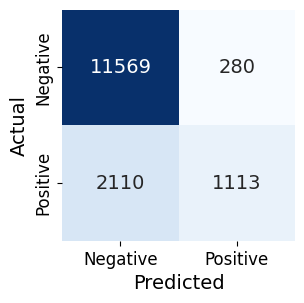

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Define the confusion matrix data
conf_matrix = np.array([[11569, 280],
                        [2110, 1113]])

# Create a dataframe for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
